# (E14)14th_Project-Chest_X-Ray
********************************************************************************
## 1. 실험환경 Set-up & 데이터 준비하기
## 2. 데이터 시각화
## 3. CNN 모델링
## 4. 데이터 imbalance 처리
## 5. 모델 훈련 & 결과 확인과 시각화
## 6. 개선하기
*********************************************************************************

## 1. 실험환경 Set-up & 데이터 준비하기

In [1]:
import re    # 정규표현식 관련된 작업에 필요한 패키지
import os    # I/O 관련된 작업에 필요한 패키지 
import pandas as pd     # 데이터 전처리 관련된 작업에 필요한 패키지
import numpy as np      # 데이터 array 작업에 필요한 패키지
import tensorflow as tf  # 딥러닝 관련된 작업에 필요한 패키지
import matplotlib.pyplot as plt    # 데이터 시각화에 관련된 작업에 필요한 패키지
from sklearn.model_selection import train_test_split  # 데이터 전처리에 필요한 패키지

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')

# BATCH_SIZE 변수
BATCH_SIZE = 16

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# EPOCH 크기 변수
EPOCHS = 25

print(ROOT_PATH)

/home/aiffel-dj39/aiffel


     배치 사이즈는 16, Epoch는 25로 설정하고 필요하면 해당 모델을 fit할 때마다 변경해주었다.

In [3]:
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*'))

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


      각각 훈련, 테스트, 그리고 검증 데이터를 불러오고 갯수를 확인해본다.

In [4]:
filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*')))

# train, test(val) dataset으로 분할. test_size에 0.2는 20%롤 의미함.
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

print(len(train_filenames))
print(len(val_filenames))

4185
1047


      훈련 데이터셋에서 20%는 다시 검증셋으로 분할해주었다.

In [5]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1090
Pneumonia images count in training set: 3095


In [6]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [7]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


In [8]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*"))])
print(CLASS_NAMES)

['PNEUMONIA' 'NORMAL']


In [9]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)를 리턴하게 합니다.

In [10]:
def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels=3)
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


      폐렴과 정상의 이미지에 각각 상태를 라벨링 해주고 확인해주었다.

In [13]:
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


      위의 과정을 테스트 데이터셋에도 똑같이 진행하여 라벨링을 해준다.

In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000):

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds_orig = prepare_for_training(train_ds)
val_ds_orig = prepare_for_training(val_ds)

## 2. 데이터 시각화

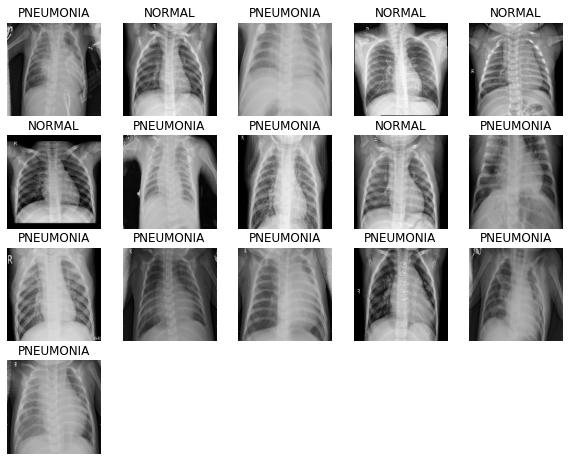

In [15]:
image_batch_orig, label_batch_orig = next(iter(train_ds_orig))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch_orig.numpy(), label_batch_orig.numpy())

      사진을 불러와 상태와 사진이 제대로 연결되어있는지 확인해줍니다.

## 3. CNN 모델링

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

      Batch Normalization과 이를 유발시키는 Dropout을 동시에 사용하는 것이 좋지 않다고 하지만 이번 케이스에서는 같이 쓰도록 합니다.

## 4. 데이터 imbalance 처리

In [17]:
# 데이터 imbalance 처리
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.92
Weight for class 1: 0.68


      weight_for_0은 'Normal' 이미지에 사용할 weight를, weight_for_1은 'Pneumonia' 이미지에 사용할 weight를 세팅합니다. 이 weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정됩니다.

## 5. 모델 훈련 & 결과 확인과 시각화

In [18]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds_orig,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_orig,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 28s 109ms/step - loss: 0.3868 - accuracy: 0.8087 - precision: 0.9515 - recall: 0.7811 - val_loss: 0.6459 - val_accuracy: 0.7519 - val_precision: 0.7519 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 25s 94ms/step - loss: 0.2451 - accuracy: 0.9054 - precision: 0.9730 - recall: 0.8971 - val_loss: 1.2765 - val_accuracy: 0.7529 - val_precision: 0.7529 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 25s 95ms/step - loss: 0.1934 - accuracy: 0.9239 - precision: 0.9747 - recall: 0.9211 - val_loss: 0.3469 - val_accuracy: 0.8183 - val_precision: 0.8058 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 25s 94ms/step - loss: 0.2013 - accuracy: 0.9262 - precision: 0.9763 - recall: 0.9225 - val_loss: 0.1551 - val_accuracy: 0.9500 - val_precision: 0.9973 - val_recall: 0.9361
Epoch 5/25
261/261 [==============================] - 24s 93ms/step - loss: 0.1599 - accuracy: 

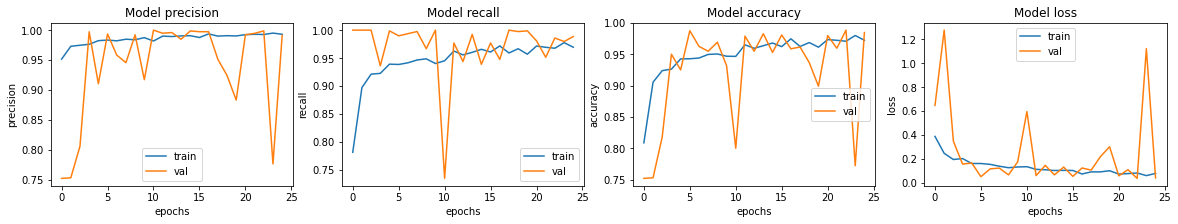

In [19]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

      학습 결과를 시각화하니 모델의 학습셋에 대한 Accuracy와 Loss는 각각 수렴하고 있지만 검증셋에서는 정확도가 치솟다가 갑자기 낮아지는 오락가락하는 모양을 보였다.

In [20]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 56ms/step - loss: 1.1000 - accuracy: 0.7740 - precision: 0.7362 - recall: 0.9949


      테스트셋으로 모델을 확인해본 결과 정확도는 약 77%로 나왔다.

## 6. 개선하기

      개선 방법으로 드롭아웃 계수 변경, 학습 중 ModelCheckpoint를 통해 성능이 좋은 모델 저장, 레이어 변경 등 여러가지를 진행해 보았지만 최종적으로 드롭아웃의 계수를 변경하는 것이 가장 도움이 되었다.

In [25]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds_flip = prepare_for_training(train_ds)
val_ds_flip = prepare_for_training(val_ds)

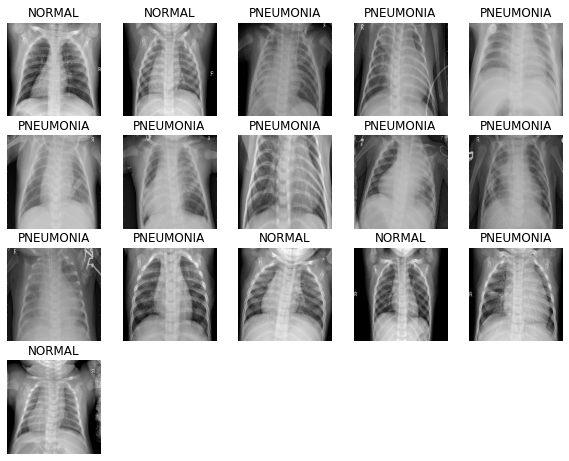

In [26]:
image_batch_flip, label_batch_flip = next(iter(train_ds_flip))

show_batch(image_batch_flip.numpy(), label_batch_flip.numpy())

In [39]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.4),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.4),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [40]:
from tensorflow.keras.callbacks import EarlyStopping

with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
#mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds_flip,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_flip,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
 #       callbacks=[es]
    )

Epoch 1/25
261/261 [==============================] - 23s 90ms/step - loss: 0.4518 - accuracy: 0.7845 - precision: 0.9418 - recall: 0.7565 - val_loss: 0.5895 - val_accuracy: 0.7404 - val_precision: 0.7404 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 23s 88ms/step - loss: 0.2741 - accuracy: 0.8851 - precision: 0.9679 - recall: 0.8742 - val_loss: 0.8572 - val_accuracy: 0.7394 - val_precision: 0.7394 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 23s 89ms/step - loss: 0.2118 - accuracy: 0.9248 - precision: 0.9748 - recall: 0.9225 - val_loss: 0.1768 - val_accuracy: 0.9365 - val_precision: 0.9718 - val_recall: 0.9416
Epoch 4/25
261/261 [==============================] - 23s 87ms/step - loss: 0.2288 - accuracy: 0.9133 - precision: 0.9734 - recall: 0.9081 - val_loss: 0.9678 - val_accuracy: 0.7529 - val_precision: 0.7498 - val_recall: 1.0000
Epoch 5/25
261/261 [==============================] - 22s 84ms/step - loss: 0.2030 - accuracy: 0

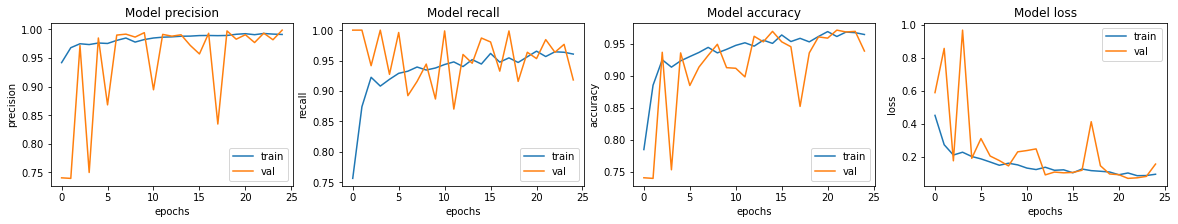

In [41]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [42]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 60ms/step - loss: 0.4741 - accuracy: 0.8638 - precision: 0.8490 - recall: 0.9513


      최종적으로 정확도는 약 86%가 나왔다

******************************************
# 결론 및 총평

      모델 개선을 위해 EarlyStopping를 설정할 경우 Val loss가 워낙 날뛰어서 제대로 진행되지 않았다. CheckPoint 또한 가장 좋은 Val Accuracy에 저장되도록 하였지만 최종적으로 가장 좋을 때도, 아닐 때도 있었다.
      다양한 시도를 진행해보았지만 결국 80~84% 언저리에서 정확도가 상승하지 않았다. 최고로 효과를 보았던 수정은 간단한 Dropout의 계수를 올린 경우였다.
      
      좌우 반전을 한 이미지를 사용한 경우에도 약 5%의 정확도 상승 효과를 볼 수 있었다.
      수정된 이미지와 하이퍼 파라미터 수정으로 결과적으로 86%의 정확도를 얻을 수 있었다.